In [1]:
# Sample API
import flowx
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 1.0

Re   = 100.0
dt   = 0.01
tmax = 10.

# Define cell-centered variable names
center_vars = ['pres', 'divv', 'asol', 'eror']
face_vars   = ['velc', 'hvar', 'asol', 'eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 1.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}

# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=10.0, dt=0.01, Re=100.0)

In [3]:
ins_vars = ['velc', 'hvar', 'divv', 'pres']

poisson_options = dict(maxiter = 2000, tol = 1e-9)
poisson_options['lu'], poisson_options['mtx'] = flowx.poisson.build_sparse(gridc, 'pres')

while scalars.variable['time'] <= scalars.variable['tmax']:
    
    # Predictor Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'predictor')

    # Divergence Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'divergence')
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_lu(gridc, 'pres', 'divv', 
                                                                             poisson_options)
    
    # Corrector Step
    flowx.ins.advance_euler(gridc, gridx, gridy, scalars, ins_vars, 'corrector')
    
    # Display stats
    if scalars.variable['nstep'] % 10 == 0:
        flowx.io.display_stats(scalars)   

    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.0109254054534377e-11
Max, Min, U   : 2.0, -0.06368604136069313
Max, Min, V   : 0.1597809848293596, -0.1597809848293596
Max, Min, P   : 1.8065545582984053, -1.8361874633499113
Max, Min, DIV : 1.6209256159527285e-14, -1.609823385706477e-14


------------ Time = 0.09999999999999999 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.892395304599606e-12
Max, Min, U   : 2.0, -0.1353463117209021
Max, Min, V   : 0.3062757789458833, -0.31416379218270396
Max, Min, P   : 1.1738665389738467, -0.8749971220330613
Max, Min, DIV : 4.884981308350689e-15, -5.551115123125783e-15


------------ Time = 0.20000000000000004 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.302088390067327e-12
Max, Min, U   : 2.0, -0.15408001946195574
Max, Min, V   : 0.32005119576803975, -0.3718032230331649
Max, Min, P   : 1.177000326520522, -0.790575005366285

------------ Time = 2.6999999999999864 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.00271515695306e-12
Max, Min, U   : 2.0, -0.2337068534155648
Max, Min, V   : 0.3460455376481449, -0.5093159557369092
Max, Min, P   : 1.2917352366973747, -0.6939143736251742
Max, Min, DIV : 8.215650382226158e-15, -6.661338147750939e-15


------------ Time = 2.7999999999999843 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.3036836214112844e-12
Max, Min, U   : 2.0, -0.23384916601536343
Max, Min, V   : 0.34607470794334994, -0.5100560818495438
Max, Min, P   : 1.29119719507456, -0.6952461791158252
Max, Min, DIV : 9.103828801926284e-15, -4.884981308350689e-15


------------ Time = 2.899999999999982 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.8470887241588317e-12
Max, Min, U   : 2.0, -0.234258114155325
Max, Min, V   : 0.34610114810461595, -0.510726943526725
Max, Min, P   : 1.2981694982129937, -0.68901717

------------ Time = 5.399999999999929 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.266345789272817e-12
Max, Min, U   : 2.0, -0.23802083481858471
Max, Min, V   : 0.3463712384107692, -0.5175950787949302
Max, Min, P   : 1.3067061056770806, -0.6897454208586247
Max, Min, DIV : 7.771561172376096e-15, -5.995204332975845e-15


------------ Time = 5.499999999999927 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.3683199904505013e-12
Max, Min, U   : 2.0, -0.2381458960259142
Max, Min, V   : 0.34637513985876667, -0.5176955296708996
Max, Min, P   : 1.3062969047477295, -0.6903166580726563
Max, Min, DIV : 7.105427357601002e-15, -5.995204332975845e-15


------------ Time = 5.599999999999925 ---------------
Number of poisson iterations    : None
Final poisson residual : 1.8725240433391492e-12
Max, Min, U   : 2.0, -0.2382609249467073
Max, Min, V   : 0.34637881027838624, -0.5177901203104749
Max, Min, P   : 1.3073351132566335, -0.68943

------------ Time = 7.69999999999988 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.2781821736925412e-12
Max, Min, U   : 2.0, -0.2394190689025959
Max, Min, V   : 0.34642177380638106, -0.5189050406888422
Max, Min, P   : 1.309578966781408, -0.6890504675504959
Max, Min, DIV : 5.995204332975845e-15, -7.105427357601002e-15


------------ Time = 7.799999999999878 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.4416195121250307e-12
Max, Min, U   : 2.0, -0.23944265495251174
Max, Min, V   : 0.34642280286596316, -0.5189319525686648
Max, Min, P   : 1.3074147319671723, -0.6912608521721704
Max, Min, DIV : 7.105427357601002e-15, -4.884981308350689e-15


------------ Time = 7.899999999999876 ---------------
Number of poisson iterations    : None
Final poisson residual : 2.2964274064958335e-12
Max, Min, U   : 2.0, -0.23946478976158575
Max, Min, V   : 0.3464237760254184, -0.5189574131245503
Max, Min, P   : 1.3120217317375493, -0.68669

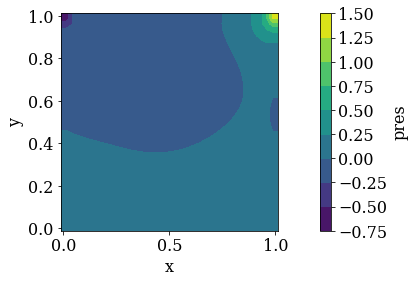

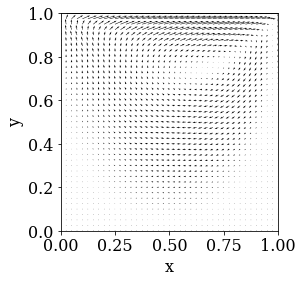

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_vector(gridx,gridy,'velc')